# SET: Learning Curve Experiments

## Set Up

In [1]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import wandb

import tensorflow as tf

from tqdm.auto import tqdm

# %load_ext autoreload
# %autoreload 2
from relational_neural_networks import *
import set_game
from utils import *

### Generate dataset for set card game

In [2]:
X, y = set_game.create_Xy_data(encode=True)
class_names = ['non-set', 'set']

In [3]:
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_res = np.array(X)[np.squeeze(res_idx)]

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_res, y_res, test_size=0.4, val_size=0.1)

In [ ]:
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

batch_size = 256
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [6]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Models

In [ ]:
# set up W&B logging
%load_ext dotenv
%dotenv

%env "WANDB_NOTEBOOK_NAME" "set-learning-curves.ipynb"

import wandb
wandb.login()

In [8]:
# define common components across models

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbCallback(
            monitor="val_loss", log_weights=False, log_gradients=False, save_model=False, save_graph=False,
            # training_data=train_ds, validation_data=val_ds,
            # labels=['non-set', 'set'], predictions=64,
            compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

fit_kwargs = {'epochs': 100}

def eval_metrics(model):

    print('test set')
    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    print(sklearn.metrics.classification_report(y_test[:,1], pred_test))

    return pred_proba_test, pred_test

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})
    
plt.style.use('seaborn-whitegrid')
def plot_learning_curve(train_sizes, accuracies):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_sizes, accuracies)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Test Accuracy')
    return fig

In [9]:
n_entities, base_encoding_dim = X.shape[1:]

In [10]:
max_train_size = 1000
train_size_step = 10
train_sizes = np.arange(10, max_train_size+1, step=train_size_step)

### Non-relational model: MLP

In [11]:
def create_model():
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    x = tf.keras.layers.Flatten(name='flatten')(input_)

    x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    non_rel_mlp = tf.keras.Model(input_, x, name='non_rel_mlp')
    non_rel_mlp.compile(loss=loss, optimizer=opt, metrics=metrics)

    return non_rel_mlp

In [ ]:
histories = {}
accuracies = []

for train_size in tqdm(train_sizes):

    run = wandb.init(project='SET-learning-curves', group='Non-relational MLP', name=f'train size = {train_size}')
    model = create_model()

    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    y_train_ = tf.one_hot(y_train_, 2)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

    history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    log_to_wandb(y_test, pred_proba_test, pred_test)

    acc = np.mean(pred_test==y_test[:, 1])
    accuracies.append(acc)
    histories[train_size] = history

    wandb.finish(quiet=True)

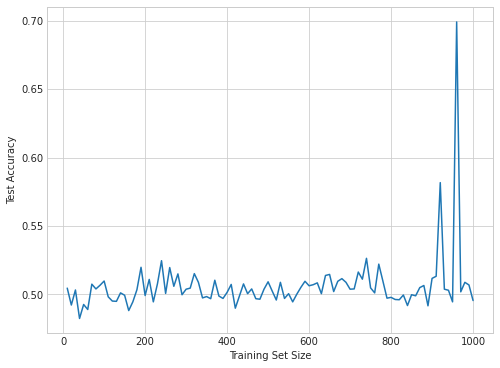

In [13]:
plot_learning_curve(train_sizes, accuracies);

### CoRelNet

In [14]:
def create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor, name='CoRelNet'):
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    if encoder_constructor is not None:
        x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)
    else:
        x = input_

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(9, activation='relu', name='dense1')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    corelnet = tf.keras.Model(input_, x, name=name)

    corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)

    return corelnet

#### CoRelNet: No Encoder

In [15]:
def create_model():
    return create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=None)

In [ ]:
histories = {}
accuracies = []

for train_size in tqdm(train_sizes):

    run = wandb.init(project='SET-learning-curves', group='CoRelNet (no encoder)', name=f'train size = {train_size}')
    model = create_model()

    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    y_train_ = tf.one_hot(y_train_, 2)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

    history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    log_to_wandb(y_test, pred_proba_test, pred_test)

    acc = np.mean(pred_test==y_test[:, 1])
    accuracies.append(acc)
    histories[train_size] = history

    wandb.finish(quiet=True)

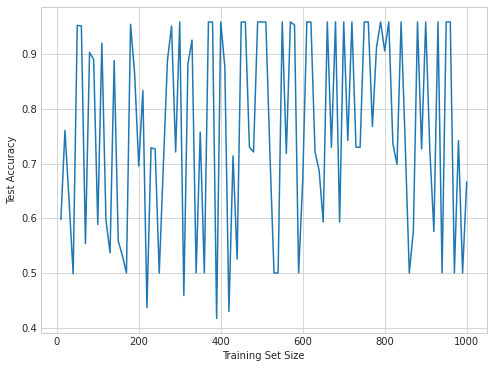

In [17]:
plot_learning_curve(train_sizes, accuracies);

## Relational Neural Network (Fixed Good Encoders)

In [18]:
## RelNN with LinearProjectionEncoder
def create_model():
    input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

    encoder_constructors = [lambda: tf.keras.layers.Dense(3, activation=None, use_bias=False)]*4
    rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
    # rel_layer.trainable = False

    x = rel_layer(input_)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    relnn = tf.keras.models.Model(input_, x, name='relnn')

    relnn.compile(loss=loss, optimizer=opt, metrics=metrics)

    # linear maps extract 1-hot 3-d vecs for each of 4 attrs
    A1 = np.array([[1, 0, 0]+[0]*9, [0, 1, 0] + [0]*9, [0, 0, 1] + [0]*9]).astype(float)
    A2 = np.roll(A1, shift=3)
    A3 = np.roll(A1, shift=6)
    A4 = np.roll(A1, shift=9)

    # fix entity encoders
    for entity_encoder, A in zip(rel_layer.entity_encoders, (A1, A2, A3, A4)):
        entity_encoder.encoder.set_weights([A.T])
        entity_encoder.trainable = False

    return relnn

In [ ]:
histories = {}
accuracies = []

for train_size in tqdm(train_sizes):

    run = wandb.init(project='SET-learning-curves', group='RelNN (fixed good linear encoders)', name=f'train size = {train_size}')
    model = create_model()

    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    y_train_ = tf.one_hot(y_train_, 2)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

    history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    log_to_wandb(y_test, pred_proba_test, pred_test)

    acc = np.mean(pred_test==y_test[:, 1])
    accuracies.append(acc)
    histories[train_size] = history

    wandb.finish(quiet=True)

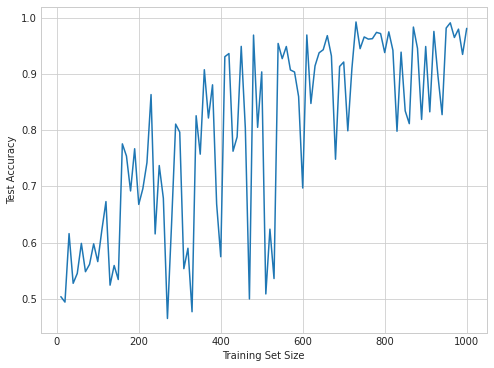

In [20]:
plot_learning_curve(train_sizes, accuracies);

## Relational Neural Network (End-to-end Good Encoders)

In [21]:
## RelNN with LinearProjectionEncoder
def create_model():
    input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

    encoder_constructors = [lambda: tf.keras.layers.Dense(3, activation=None, use_bias=False)]*4
    rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
    # rel_layer.trainable = False

    x = rel_layer(input_)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    relnn = tf.keras.models.Model(input_, x, name='relnn')

    relnn.compile(loss=loss, optimizer=opt, metrics=metrics)

    return relnn

In [ ]:
histories = {}
accuracies = []

for train_size in tqdm(train_sizes):

    run = wandb.init(project='SET-learning-curves', group='RelNN (learned linear encoders)', name=f'train size = {train_size}')
    model = create_model()

    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    y_train_ = tf.one_hot(y_train_, 2)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

    history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    log_to_wandb(y_test, pred_proba_test, pred_test)

    acc = np.mean(pred_test==y_test[:, 1])
    accuracies.append(acc)
    histories[train_size] = history

    wandb.finish(quiet=True)

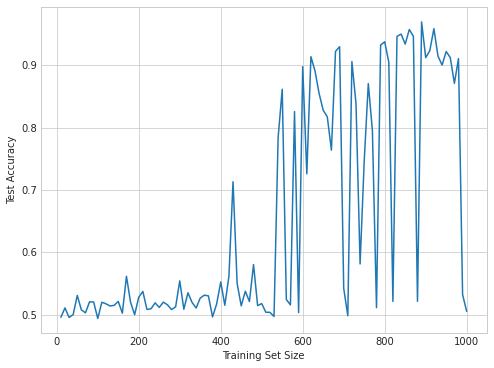

In [23]:
plot_learning_curve(train_sizes, accuracies);